<a href="https://colab.research.google.com/github/m-aliabbas/EvolutionaryComputing/blob/master/GradientBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading and Preprocessing Data

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls '/content/drive/My Drive/PreTrainModels/'

dataset123.csv


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the dataset



In [6]:
dataset = pd.read_csv('/content/drive/My Drive/PreTrainModels/dataset123.csv')
dataset.shape

(3680, 513)

#Split into Train , Validation and Test Sets

In [0]:
from sklearn.model_selection import train_test_split
dftrain,dftest= train_test_split(dataset, test_size=0.1, random_state=42)

In [0]:
dftrain,dfvalid= train_test_split(dftrain, test_size=0.2, random_state=42)

Getting Features Name

In [0]:
featureCol=[]
for i in range(512):
    featureCol+=[str(i)]

In [17]:
dftrain.shape,dfvalid.shape,dftest.shape

((2649, 513), (663, 513), (368, 513))

Ploting Historgram of Data in sets

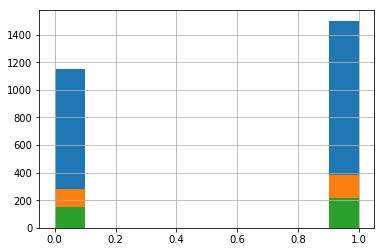

In [18]:
dftrain['label'].hist()
dfvalid['label'].hist()
dftest['label'].hist()

In [0]:
featureCol+=['label']

In [0]:
testCol=featureCol[:512]

In [21]:
len(testCol)

512

Initalization of sets according to LightGB . it is optional

In [0]:
import lightgbm as lgb
import gc
gc.collect()

dtrain = lgb.Dataset(dftrain[featureCol[:512]].values, label=dftrain['label'].values,
                      feature_name=featureCol[:512]
                      )
dvalid = lgb.Dataset(dfvalid[featureCol[:512]].values, label=dftest['label'].values,
                      feature_name=featureCol[:512],
                      )

Initial Paramets

#Random Search for Hyperparamters Tuning

In [0]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.1,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'verbose': 100,
          'num_class' : 1,
          'metric' : 'binary_error'}


Some Parameters are initalization as a population. On which we performs Random Search / Grid Search to Choose Optimal Hyperparameters

In [0]:
gridParams = {
    'learning_rate': [0.01,0.9,0.0001,0.35,0.1,0.0001,0.2,0.003,0.009,0.02],
    'n_estimators': [40,100,120,12,20,50,90,140,105],
    'num_leaves': [100,200,300,40,60,50,350,400],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65,0.9,0.7,0.85, 0.66,0.7,0.9],
    
    
    }

In [0]:
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'],
                         verbose=100
                        
                        )

In [25]:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

Random Search with 100 Iteration , it takes very large time so I am commiting the code beacause we get optimal values which are below

In [0]:
from sklearn.metrics import f1_score
def evaluate_macroF1_lgb(truth, predictions):  
    f1 = f1_score(truth, predictions, average='binary')
    return ('macroF1', f1, True) 

In [0]:
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


gs = RandomizedSearchCV(
    estimator=mdl, param_distributions=gridParams, 
    n_iter=100,
    scoring='roc_auc',
    cv=2,
    n_jobs=1,
    refit=True,
    random_state=314,
    verbose=True)

In [0]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : 'auc', 
            "eval_set" : [dfvalid],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [29]:
gs.fit(dftrain[testCol], dftrain['label'])

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.6min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg...
                                        'colsample_bytree': [0.65, 0.9, 0.7,
                                                 

#Train Model WIth Best Parameters Optimized by Random Search

In [30]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.980766830842397 with params: {'random_state': 501, 'objective': 'binary', 'num_leaves': 100, 'n_estimators': 120, 'learning_rate': 0.1, 'colsample_bytree': 0.85, 'boosting_type': 'gbdt'} 


In [0]:
bestParams=gs.best_params_

In [0]:
params={'random_state': 501, 'objective': 'binary', 'num_leaves': 100, 'n_estimators': 100, 'learning_rate': 0.2, 'colsample_bytree': 0.85, 'boosting_type': 'gbdt'}

In [0]:
mdl = lgb.LGBMClassifier(
                        **bestParams
                         
                        )

In [33]:
mdl.fit(dftrain[testCol],dftrain['label'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.85,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=120, n_jobs=-1, num_leaves=100, objective='binary',
               random_state=501, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
lab=dftest['label']

In [0]:
dftest1=dftest.drop('label',axis=1)

In [0]:

y_pred=mdl.predict(dftest1)


In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lab, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,lab)

Calculating Values according to
$$ Recall = \frac{TruePositive}{TruePositive+False Nagitive}=9535603715170278$$
$$ Precision = \frac{TruePositive}{TruePositive+FalsePositive}$$
$$F1 = \frac{2 \cdot precision\cdot recall}{precision+ recall}$$

In [39]:
conf=cm
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision of Model =",precision,"Recall of Model ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score of Model =',f1)

Precision of Model = 0.9539170506912442 Recall of Model  0.9627906976744186
F1 Score of Model = 0.9583333333333333


Learning Curves

Automatically created module for IPython interactive environment


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


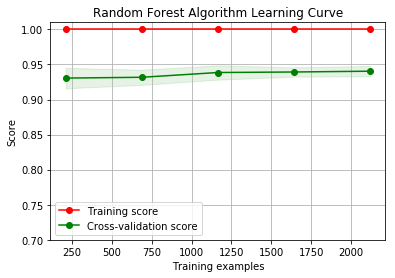

In [40]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt





title = "Random Forest Algorithm Learning Curve"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

estimator=lgb.LGBMClassifier(
                        boosting_type='gbdt',
          objective = 'binary',
          n_jobs = 2, # Updated from 'nthread'
          silent = True,
                     random_state=501,
                         num_leaves=80,
                         n_estimators=80,
                         learning_rate=0.2,
                         colsample_bytree=0.85,
                         
                        )
plot_learning_curve(estimator, title, dftrain[testCol],dftrain['label'], ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()